# Reducing the data from Galaxy Zoo Mini

Citizen science data typically comes in the form of "classifications". For example, below is an excerpt from a real classification provided to the Galaxy Zoo 2 project:
```
'classification_id': 166955279
'user_name' 'not-logged-in-67b5f42546e2dcd6bcb1',
'user_id' nan,
'workflow_id': 10581,
'workflow_name': 'Classic',
'created_at': '2019-05-21 13:38:34 UTC':
'subject_data': {'16215345': {'ra': 198.27742535025737, 'dec': -0.8980790615027351, 'nsa_id': 10288, 'iauname': 'J131306.57-005353.0', 'redshift': 0.08395665}},
'annotations': [
    {'task': 'T0',
    'task_label': 'Is the galaxy simply smooth and rounded, with no sign of a disk?',
    'value': 'Smooth'},
    {'task': 'T1',
    'task_label': 'How rounded is it?',
    'value': 'Cigar-shaped'},
    {'task': 'T11',
    'task_label': 'Is the galaxy merging or disturbed?',
    'value': None'},
    {'task': 'T10',
    'task_label': 'Do you see any of these rare features?',
    'value': Nothing Unusual'}
],

```

Let's break this down:
- `user_id` is the volunteer ID who classified this subject
- `subject_data` contains the galaxy's ID, and some useful info about it
- `annotations` contains the information the volunteer provided

Our goal is to take all of these classifications and reduce them into useable scientific data. **This process will have 3 steps:**
1. Reduce these classifications into a useable format
2. Determine the **vote fraction** for "features or disk" for each galaxy
3. Identify (and deal with) **highly inaccurate volunteers**

Then, we'll regroup and evaluate the reliability of our volunteer-provided data.


In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import json

### Step 1: Reduce the classifications into a useable format

- First, we'll open the data dump in Pandas and examine one row

In [2]:
dfGZMiniData = pd.read_csv('galaxy_zoo_mini_data_dump.csv')

print('FIRST ROW:')
print(dfGZMiniData.iloc[0])
print()
print('subject_data:', dfGZMiniData.iloc[0]['subject_data'])
print()
print('annotations:', dfGZMiniData.iloc[0]['annotations'])

FIRST ROW:
classification_id                                                    0
user_id                                                            166
subject_id                                                          37
subject_data         {"37": {"num_classifications": 1, "sdss_specob...
annotations          [{"task": "T0", "task_label": "Is the galaxy s...
Name: 0, dtype: object

subject_data: {"37": {"num_classifications": 1, "sdss_specobjid": 2980368179500443648}}

annotations: [{"task": "T0", "task_label": "Is the galaxy simply smooth and rounded, with no sign of a disk?", "value": "Smooth"}]


- There is important data in the columns "subject_data" and "annotations". These columns are stored as strings of text in a format called JSON (JavaScript Object Notation). Our first task is to load these into Python code with the function `json.loads`:

In [3]:
dfGZMiniData['subject_data_json'] = dfGZMiniData['subject_data'].apply(json.loads)
dfGZMiniData['annotations_json'] = dfGZMiniData['annotations'].apply(json.loads)

- Next, we will extract two key pieces of information: The subject ID from `subject_data` and the volunteer's answer to the first task `T0`.

In [4]:
# From "subject_data_json", extracts each galaxy's Sloan Digital Sky Survey ID
# From "annotations_json", extracts volunteer responses for the task "T0"
sdss_id_list = []
t0_answer_list = []
for rowIndex in range(len(dfGZMiniData)):
    dfGZMiniRow = dfGZMiniData.iloc[rowIndex]
    
    # Extracts the galaxy's SDSS specobjid value
    subject_id_string = str(dfGZMiniRow['subject_id'])
    subject_data_json = dfGZMiniRow['subject_data_json']
    sdss_id = subject_data_json[subject_id_string]['sdss_specobjid']
    
    # Extracts the volunteer's answer value
    annotations_json = dfGZMiniRow['annotations_json']
    t0_answer = annotations_json[0]['value']
    
    # Appends these values to their respective lists
    sdss_id_list.append(sdss_id)
    t0_answer_list.append(t0_answer)

dfGZMiniData['SDSS_specobjid'] = sdss_id_list
dfGZMiniData['T0_answer'] = t0_answer_list

# Finally, creates a new column that is "1" if "T0_answer"=="Features or disk", "0" if "Smooth"
# YOUR CODE HERE
dfGZMiniData['T0_answer_features_or_disk'] = (dfGZMiniData['T0_answer'].values=='Features or disk').astype(int)


In [5]:
dfGZMiniData.iloc[0]

classification_id                                                             0
user_id                                                                     166
subject_id                                                                   37
subject_data                  {"37": {"num_classifications": 1, "sdss_specob...
annotations                   [{"task": "T0", "task_label": "Is the galaxy s...
subject_data_json             {'37': {'num_classifications': 1, 'sdss_specob...
annotations_json              [{'task': 'T0', 'task_label': 'Is the galaxy s...
SDSS_specobjid                                              2980368179500443648
T0_answer                                                                Smooth
T0_answer_features_or_disk                                                    0
Name: 0, dtype: object

### Step 2: Determine the vote fraction for "features or disk" for each galaxy

- For each subject, we now have to determine the fraction of volunteers who voted for the answer "features or disk".
    - There are a number of ways to do this; for this exercise we will use the `pandas` functions `groupby` and `agg`.
    - This will create a new data frame, called `dfSubjects`, with exactly 1 row per subject

In [6]:
# Groups the data frame by subject
dfGZMiniData_SubjectGrouped = dfGZMiniData.groupby('subject_id')

# Creates an "aggregated" data frame. This has 4 columns:
# - sdss_specobjid: The ID of the galaxy in SDSS
# - user_id_list: A list of the users who classified this galaxy
# - T0_answer_features_or_disk_list: A list of all volunteer votes
# - T0_answer_features_or_disk_mean: The fraction of volunteers who voted for "features or disk"
dfSubjects = dfGZMiniData_SubjectGrouped.agg(
    sdss_specobjid = pd.NamedAgg(column='SDSS_specobjid', aggfunc='first'),
    user_id_list = pd.NamedAgg(column='user_id', aggfunc=list),
    T0_answer_features_or_disk_list = pd.NamedAgg(column='T0_answer_features_or_disk', aggfunc=list),
    T0_answer_features_or_disk_mean = pd.NamedAgg(column='T0_answer_features_or_disk', aggfunc=np.mean)
)

# Prints the first row of the new data frame as an example
print(dfSubjects.iloc[0])

sdss_specobjid                                                    956054538329024512
user_id_list                       [22, 55, 142, 73, 66, 114, 72, 166, 63, 39, 18...
T0_answer_features_or_disk_list    [1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, ...
T0_answer_features_or_disk_mean                                                 0.15
Name: 1, dtype: object


- **Plot:** Make a histogram of the vote fractions for "features or disk" (stored in the `T0_answer_features_or_disk` column) for all of these galaxies. `plt.hist` from matplotlib may help
    - About how many galaxies is the crowd "certain" about? How many are they evenly split on? 

Text(0, 0.5, 'Galaxy count')

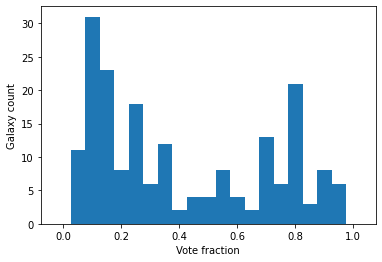

In [7]:
# YOUR CODE HERE

plt.hist(dfSubjects['T0_answer_features_or_disk_mean'], bins=np.arange(-0.025 ,1.025 + 0.025, 0.05))
plt.xlabel('Vote fraction')
plt.ylabel('Galaxy count')

- **Plot:** Now, select 10 galaxy IDs from the `SDSS_specobjid` that are very "disky" (high vote fraction), 10 that are very "smooth" (low vote fraction), and 10 that are in the middle. Use the `plotGalaxyImages` function below to plot each of these.
    - The "very disky" galaxies are provided as an example

In [8]:
''' Takes in a list of 10 galaxy `specobjids` and 10 `vote_fractions` provided by volunteers
Plots these galaxies and labels them by their vote fractions

specobjids: List of the 10 galaxy specobjids from SDSS to plot
vote_fractions: List of the volunteer vote fraction for each galaxy (to display above the image)
suptitle: Supertitle for the plot (ignored by default)
'''
def plotGalaxyImages(specobjids, vote_fractions, suptitle=None):
    rows, cols = 2, 5
    fig, axes = plt.subplots(rows, cols, figsize=(cols*4, rows*4+1))
    for idx, (ax, soi) in enumerate(zip(axes.ravel(), specobjids)):
        img = plt.imread('galaxy_pngs/%i.png' % soi)
        
        # Emphasizes the blue color band 
        img[:,:,2] = (img[:,:,2])**0.8
        ax.imshow(img)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        ax.set_title('Features or disk: %.3f' % vote_fractions[idx])
    if suptitle: plt.suptitle(suptitle, fontsize=16)
    plt.show()

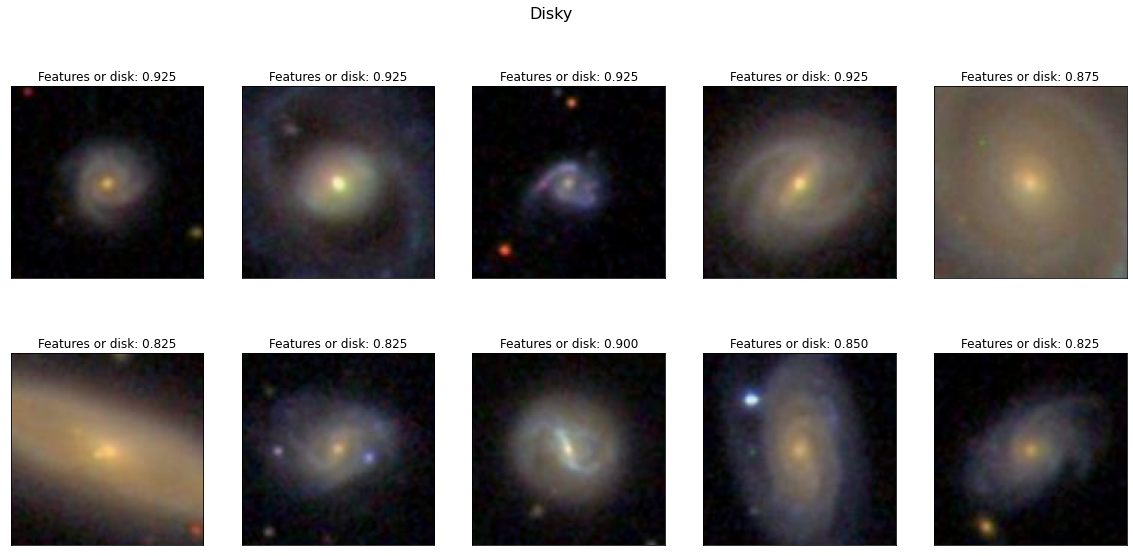

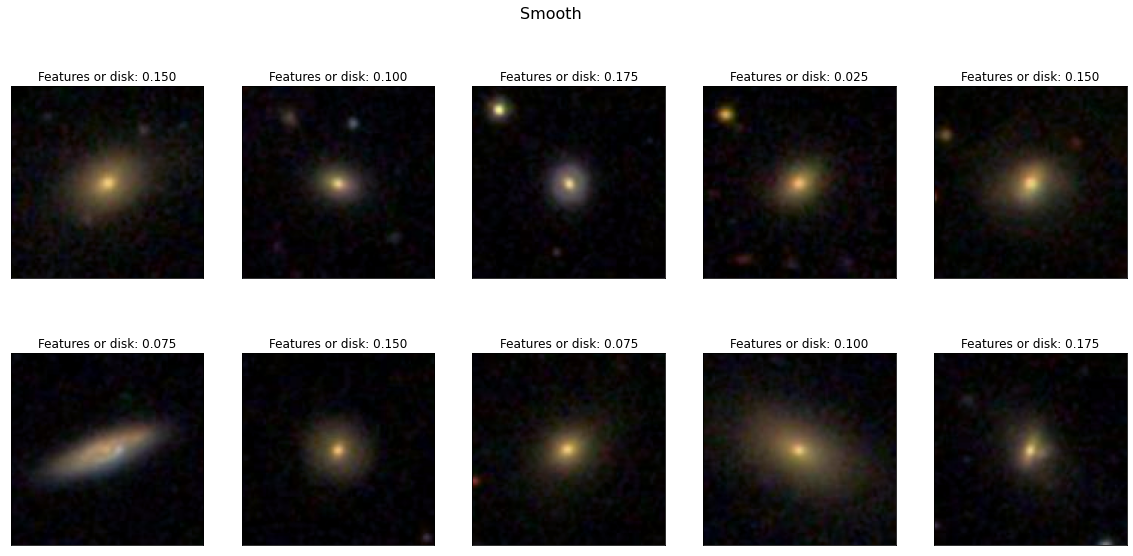

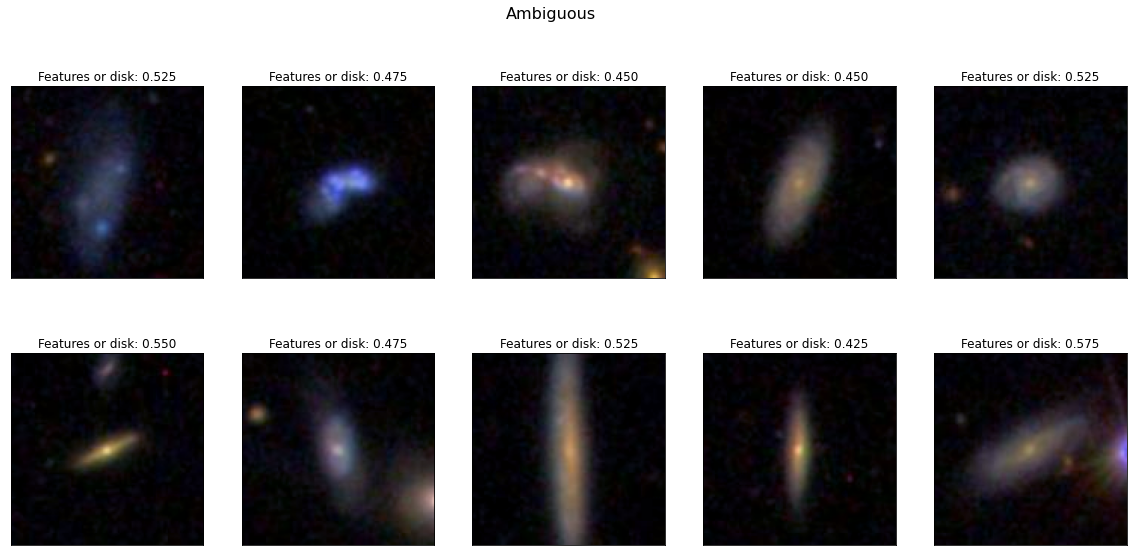

In [9]:
# Plot 10 very "disky" galaxies according to the crowd's votes 

dfSubjects_disky = dfSubjects[dfSubjects['T0_answer_features_or_disk_mean'] > 0.8]

specobjids = dfSubjects_disky['sdss_specobjid'].values[:10]
vote_fractions = dfSubjects_disky['T0_answer_features_or_disk_mean'].values[:10]
plotGalaxyImages(specobjids, vote_fractions, suptitle='Disky')

# Plot 10 very "smooth" galaxies according to the crowd's votes 
# YOUR CODE HERE

dfSubjects_smooth = dfSubjects[dfSubjects['T0_answer_features_or_disk_mean'] < 0.2]

specobjids = dfSubjects_smooth['sdss_specobjid'].values[:10]
vote_fractions = dfSubjects_smooth['T0_answer_features_or_disk_mean'].values[:10]
plotGalaxyImages(specobjids, vote_fractions, suptitle='Smooth')

# Plot 10 "ambiguous/uncertain" galaxies according to the crowd's votes 
# YOUR CODE HERE

dfSubjects_ambiguous = dfSubjects[
    (dfSubjects['T0_answer_features_or_disk_mean'] > 0.4) &
    (dfSubjects['T0_answer_features_or_disk_mean'] < 0.6)
]

specobjids = dfSubjects_ambiguous['sdss_specobjid'].values[:10]
vote_fractions = dfSubjects_ambiguous['T0_answer_features_or_disk_mean'].values[:10]
plotGalaxyImages(specobjids, vote_fractions, suptitle='Ambiguous')


Nice! We now have approximate vote fractions that capture whether our galaxies are just smooth & rounded, or if they have disks or other interesting features.
- In Galaxy Zoo 2, this question would be followed up by more targeted questions: For example, if a volunteer answered "features or disk", they would be asked for more details about the galaxy's "features".

However, what if a volunteer didn't read the instructions... or just clicked on the "opposite" answer each time to mess with the scientists? (Unfortunately, a few volunteers for Galaxy Zoo projects actually do this.) We need to make sure these highly inaccurate classifications don't negatively impact the results.

### Step 3: Identify (and deal with) highly-inaccurate volunteers

Our goal in step 3 is to determine each volunteer's **"mean consistency"**, which measures their average agreement with other volunteers. If a volunteer's consistency is very low, it is likely they didn't read the instructions, or they may be purposely voting incorrectly.
- For this project, "consistency" is simply the **fraction of volunteers who voted the same as they did** on each subject.
- (Note - consistency can be more complex if a question has multiple possible answers.)

First, we will need to **group these classifications by volunteer ID**. We will do this by creating a new data frame using `groupby` and `agg`, like we did for the subjects:

In [10]:
dfVolunteers = dfGZMiniData.groupby('user_id').agg(
    num_subjects_classified = pd.NamedAgg(column='subject_id', aggfunc=len),
    subject_ids_classified = pd.NamedAgg(column='subject_id', aggfunc=list),
    T0_features_or_disk_answers = pd.NamedAgg(column='T0_answer_features_or_disk', aggfunc=list)
)

We can use this data frame to see some statistics about the volunteer distribution.

**Plot:** In the cell below, plot a histogram of  the number of subjects classified by each volunteer (`dfVolunteers['num_subjects_classified']`)
- Notice that many volunteers classified only 5-10 subjects, while others classified over 100.

Text(0, 0.5, 'Volunteer count')

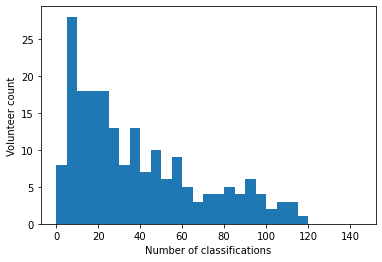

In [11]:
# YOUR CODE HERE
plt.hist(dfVolunteers['num_subjects_classified'], np.arange(0, 150, 5))
plt.xlabel('Number of classifications')
plt.ylabel('Volunteer count')

Next, we'll use this data frame to compute the **mean consistency of each volunteer**, averaged over all of the subjects they classified.

In [12]:
# Adds the mean consistency to each volunteer list

volunteer_mean_consistencies = []

# For each volunteer:
for user_id in dfVolunteers.index:
    dfVolunteersRow = dfVolunteers.loc[user_id]
    
    volunteer_consistencies = []
    
    # For each subject the volunteer classified:
    for subject_id, volunteer_picked_features_or_disk in zip(dfVolunteersRow['subject_ids_classified'], dfVolunteersRow['T0_features_or_disk_answers']):
        dfSubjectsRow = dfSubjects.loc[subject_id]
        
        # Note the agreement ("consistency") between this volunteer and others who classified the same subject
        subject_features_or_disk_vote_fraction = dfSubjectsRow['T0_answer_features_or_disk_mean']
        
        # We need to compute consistency, which is equal the fraction of volunteers
        # who voted the same as this volunteer
        #
        # Use the variables `subject_features_or_disk_vote_fraction` and
        # `volunteer_picked_features_or_disk` to help you
        #
        # YOUR CODE HERE
        if volunteer_picked_features_or_disk:
            consistency = subject_features_or_disk_vote_fraction
        else:
            consistency = 1-subject_features_or_disk_vote_fraction
        
        volunteer_consistencies.append(consistency)
    
    # Now, take the average consistency for this volunteer
    volunteer_mean_consistencies.append(np.mean(volunteer_consistencies))

# Add this as a column to the volunteer dataframe
dfVolunteers['mean_consistency'] = volunteer_mean_consistencies

**Plot:** In the cell below, make a scatterplot of the **mean consistency of volunteers** (from `dfVolunteers['mean_consistency']`) vs. the **number of subjects they classified** (from `dfVolunteers['num_subjects_classified']`).

- **Take note:** What do you notice about the volunteers with very low consistencies?

Text(0, 0.5, 'Mean consistency')

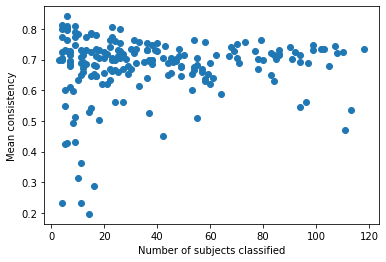

In [13]:
# YOUR CODE HERE
plt.scatter(dfVolunteers['num_subjects_classified'], dfVolunteers['mean_consistency'])
plt.xlabel('Number of subjects classified')
plt.ylabel('Mean consistency')

Remember, consistency measures a volunteer's agreement with the crowd.
- A consistency of ~0.5 means that a volunteer is effectively classifying things at random
- A consistency of <0.5 suggests that the volunteer may be picking the wrong answers on purpose

We will now apply a "weight" to each volunteer. First, we will use the actual formula that was used by Galaxy Zoo 2: Volunteers with **consistencies above 0.6** will be left alone, while those with **consistencies below 0.6** will have their votes "downweighted" in the calculations.

In [14]:
def get_volunteer_weight(mean_consistency):
    # This is the actual formula used for Galaxy Zoo 2; it downweights the ~5% poorest classifiers
    return min(1, (mean_consistency/0.6)**8.5) 

dfVolunteers['vote_weight'] = [get_volunteer_weight(c) for c in dfVolunteers['mean_consistency']]

Finally, we will recalculate the vote fractions using these volunteer weights.
- In the cell below, complete the line that computes the weighted vote fraction for each subject.

In [15]:
# Reweights the vote averages using the weighted votes

weighted_vote_fractions = []

# For each subject...
for rowIdx, dfSubjectsRow in dfSubjects.iterrows():
    # Take the user IDs of all volunteers who classified the subject
    user_ids = dfSubjectsRow['user_id_list']
    
    # Get the volunteer weights from the user IDs
    votes = np.array(dfSubjectsRow['T0_answer_features_or_disk_list'])
    weights = np.array([dfVolunteers.loc[user_id]['vote_weight'] for user_id in user_ids])
    
    # Compute the *weighted* vote fractions for each subject
    # This is equal to the sum of votes * weights, divided by the sum of the weights
    #
    # YOUR CODE HERE
    weighted_vote_fraction = np.sum(votes * weights) / np.sum(weights) 
    weighted_vote_fractions.append(weighted_vote_fraction)
    
# Assign the weighted vote fractions to a new column
dfSubjects['T0_answer_features_or_disk_weighted'] = weighted_vote_fractions

**Plot:** In the cell below, make a scatterplot of the weighted vote fraction (`dfSubjects['T0_answer_features_or_disk_mean']`) versus the original, unweighted vote fraction (`dfSubjects['T0_answer_features_or_disk_weighted']`).

- **Experiment:** What happens to this plot if you rerun the code with a different "weight" formula? (Eg: Assigning each volunteer a weight proportional to their consistency?)

Text(0, 0.5, 'Vote fraction (after weighting)')

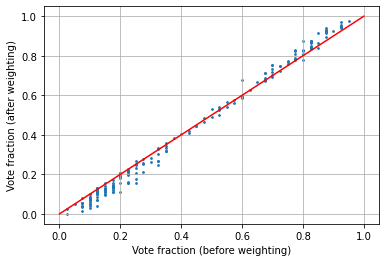

In [16]:
# YOUR CODE HERE
plt.scatter(dfSubjects['T0_answer_features_or_disk_mean'], dfSubjects['T0_answer_features_or_disk_weighted'], s=3)

# Adds a 1-1 line, a grid, and axis labels
plt.plot([0,1], [0,1], color='r')
plt.grid()
plt.xlabel('Vote fraction (before weighting)')
plt.ylabel('Vote fraction (after weighting)')

### Takeaways

The results here are very similar to what is described in the Galaxy Zoo 2 release paper ([Willet et al. 2013](https://arxiv.org/pdf/1308.3496.pdf)).
- Volunteers are able to identify **clear disks** and **clear smooth galaxies**, with an ambiguous group in between.
- A small group of volunteers (<10%) classified things at random, or worse.
    - However, most of these volunteers classified only ~10 galaxies before stopping. Their classifications did not overwhelm the dataset.
- **Overall, the crowd consensus for each galaxy is stable**. Volunteers generally achieve 60-80% agreement, and this is barely affected by the 5-10% of volunteers who were very inaccurate.

Note that, for this sort of question, 60-80% agreement between volunteers is reasonable. This can change for more complex or difficult questions -- particularly if volunteers aren't very well instructed on what to do!

---

# Using Galaxy Zoo Mini for science

So far, we've computed the vote fractions for "Features or disk" vs. "smooth" for our sample of 190 galaxies from Galaxy Zoo Mini. But why? In fact, before citizen science techniques were used, it was very difficult to select for large samples of "smooth" or "disk" galaxies without an astronomer examining each of them visually.

As a way of getting around this, **many astronomers used (and still use!) COLOR as a proxy for galaxy morphology**. To select for "smooth" galaxies, redder galaxies were used, with bluer colors used to select "disks". This was not done with accuracy in mind; instead, it was done because color is much easier to measure than 

However, according to [Smethurst et al. 2022](https://arxiv.org/pdf/2112.04507.pdf), **color is NOT a good way of selecting for galaxy morphology.** Many galaxies with red color actually have disk-like morphologies (and vice-versa).

- If you'd like to learn more, the first author of this paper (Rebecca Smethurst) made a [Youtube video explaining the paper in more detail](https://www.youtube.com/watch?v=H6UBjbio5-A).

In this activity, we will repeat the Smethurst et al. experiment by comparing the **colors** and **volunteer-identified morphologies** of galaxies in the Galaxy Zoo Mini sample.

First, we'll load a database of the magnitudes of these galaxies in each of the five SDSS color bands, (u,g,r,i,z).
- We'll then merge this data with the `dfSubjects` data containing vote fractions for each galaxy.
- We'll also compute the "color" of each galaxy, defined as $g-r$ (the magnitude in the SDSS g band minus the magnitude in the r band)

In [17]:
# Loads the photometry data frame
dfGZMiniPhotometry = pd.read_csv('galaxy_zoo_mini_photometry.csv')

# Merges it with the data frame with Galaxy Zoo Mini subject information
dfSubjectsPhotometry = dfSubjects.merge(
    dfGZMiniPhotometry,
    how='inner',
    left_on='sdss_specobjid',
    right_on='specobjid'
)

# Computes g-r color
dfSubjectsPhotometry['g-r_color'] = dfSubjectsPhotometry['petroMag_g'] - dfSubjectsPhotometry['petroMag_r']

print('FIRST ROW:')
print(dfSubjectsPhotometry.iloc[0])

FIRST ROW:
sdss_specobjid                                                        956054538329024512
user_id_list                           [22, 55, 142, 73, 66, 114, 72, 166, 63, 39, 18...
T0_answer_features_or_disk_list        [1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, ...
T0_answer_features_or_disk_mean                                                     0.15
T0_answer_features_or_disk_weighted                                             0.094826
specobjid                                                             956054538329024512
ra                                                                             196.74643
dec                                                                             5.836596
petroMag_u                                                                      18.66374
petroMag_g                                                                       16.7651
petroMag_r                                                                      15.83242
petroMag_i

- According to Smethurst et al. 2022, the best way of dividing galaxies into different morphologies is by splitting them at $g-r = 0.74$:
    - Galaxies with $g-r > 0.74$ are redder, so we will assume they are smooth
    - Galaxies with $g-r < 0.74$ are bluer, so we will assume they are disks
- **Plot:** In the cell below, make a scatterplot of galaxy color (`g-r color`, y-axis) vs. morphology (`T0_answer_features_or_disk_weighted`, x-axis).

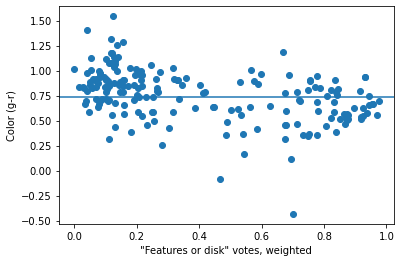

In [21]:
gr_color_cut = 0.74

# YOUR CODE HERE
plt.scatter(dfSubjectsPhotometry['T0_answer_features_or_disk_weighted'], dfSubjectsPhotometry['g-r_color'])
plt.xlabel('"Features or disk" votes, weighted')
plt.ylabel('Color (g-r)')
plt.axhline(gr_color_cut)

You should be able to see that there is **no color cut** that can neatly divide volunteer-identified disks from spirals! If you selected on color alone, the purity of your samples would be very low... at least, assuming that the volunteer labels are accurate.

Let's finish by examining what these galaxies look like. In the cell below, we will plot both red ($g-r > 0.74$) and blue ($g-r < 0.74$) galaxies, dividing them between disk (with `T0_answer_features_or_disk_weighted`$ > 0.8$) and smooth disks (with `T0_answer_features_or_disk_weighted`$ < 0.2$)

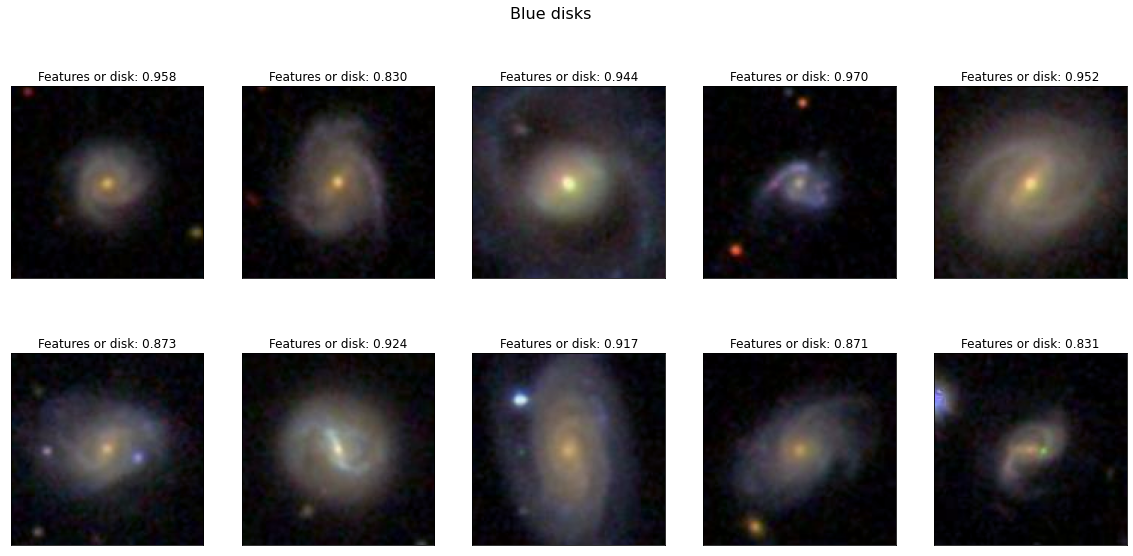

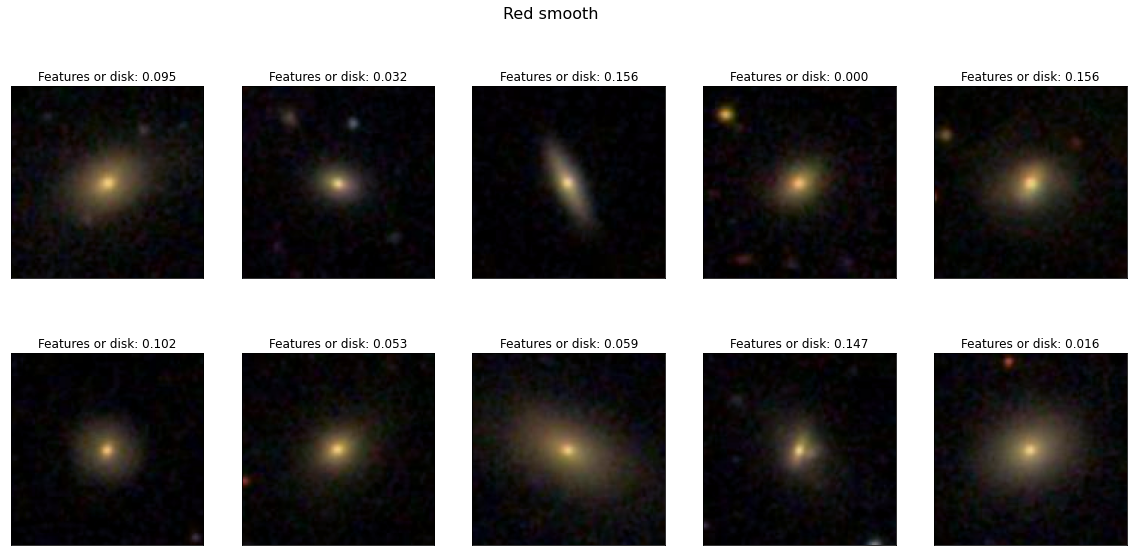

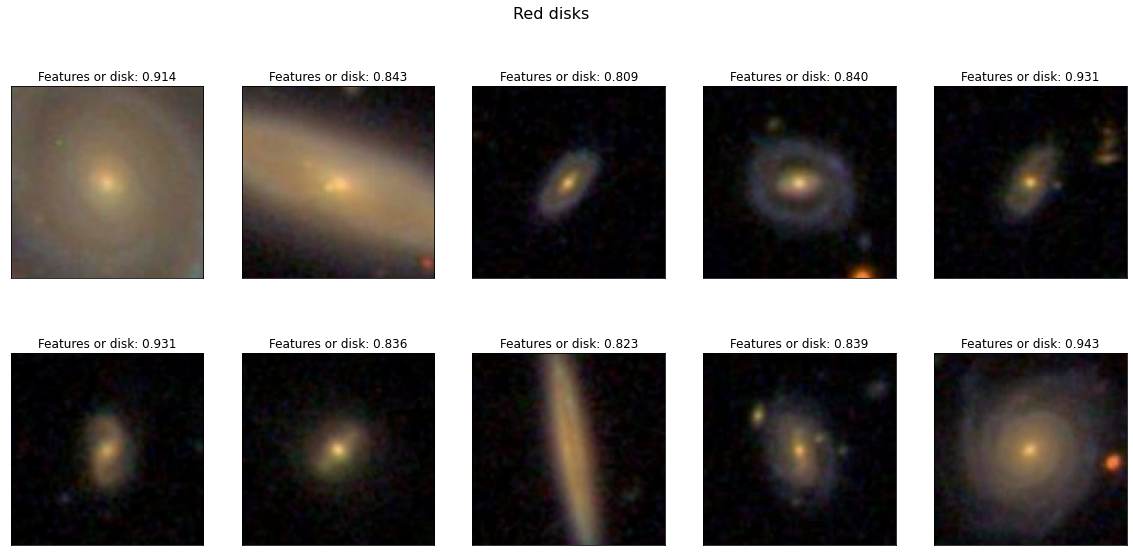

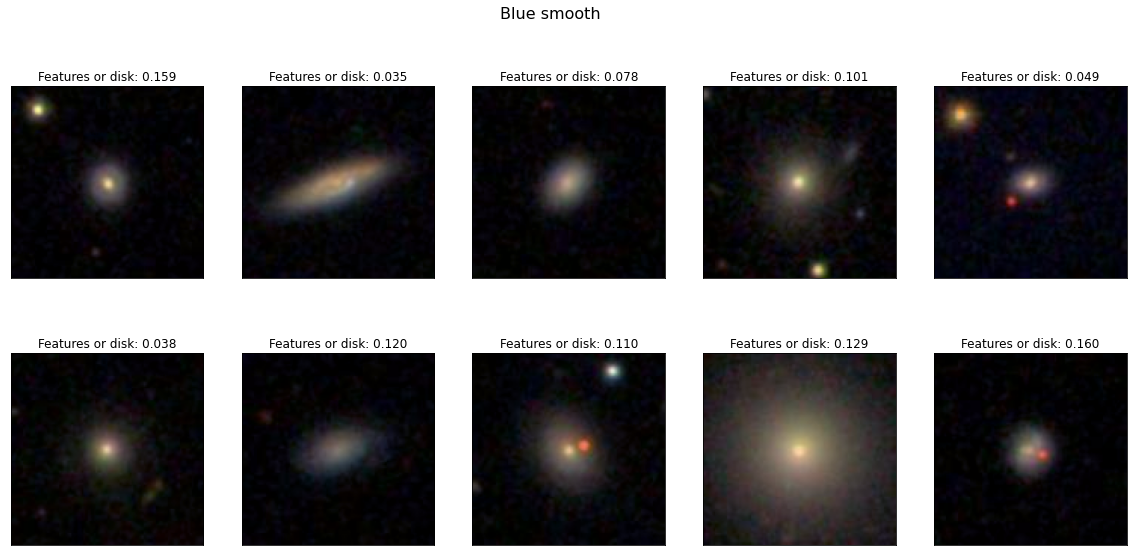

In [19]:
# Plots a stamp sheet of 10 blue disks (g-r color < 0.74, weighted vote fraction > 0.8)

blue_disks = dfSubjectsPhotometry[
    (dfSubjectsPhotometry['g-r_color'] < 0.74) &
    (dfSubjectsPhotometry['T0_answer_features_or_disk_weighted'] > 0.8)
].iloc[:10]
plotGalaxyImages(
    blue_disks['specobjid'].values,
    blue_disks['T0_answer_features_or_disk_weighted'].values,
    'Blue disks'
)

# Plot a similar galaxy stamp sheet for blue smooth, red disk, and red smooth galaxies.
#
# Following Smethurst+22:
# - Use T0_answer_features_or_disk_weighted > 0.8 to select disks
# - Use T0_answer_features_or_disk_weighted < 0.2 to select smooth galaxies
#
# YOUR CODE HERE

red_smooth = dfSubjectsPhotometry[
    (dfSubjectsPhotometry['g-r_color'] > 0.74) &
    (dfSubjectsPhotometry['T0_answer_features_or_disk_weighted'] < 0.2)
].iloc[:10]
plotGalaxyImages(
    red_smooth['specobjid'].values,
    red_smooth['T0_answer_features_or_disk_weighted'].values,
    'Red smooth'
)

red_disks = dfSubjectsPhotometry[
    (dfSubjectsPhotometry['g-r_color'] > 0.74) &
    (dfSubjectsPhotometry['T0_answer_features_or_disk_weighted'] > 0.8)
].iloc[:10]
plotGalaxyImages(
    red_disks['specobjid'].values,
    red_disks['T0_answer_features_or_disk_weighted'].values,
    'Red disks'
)

blue_smooth = dfSubjectsPhotometry[
    (dfSubjectsPhotometry['g-r_color'] < 0.74) &
    (dfSubjectsPhotometry['T0_answer_features_or_disk_weighted'] < 0.2)
].iloc[:10]
plotGalaxyImages(
    blue_smooth['specobjid'].values,
    blue_smooth['T0_answer_features_or_disk_weighted'].values,
    'Blue smooth'
)


Finally, try computing the **purity** of the disk sample and smooth sample that you would select using each of these color cuts.
- To do so, select all galaxies that are either **disks** (vote fraction > 0.8) or **smooth** (vote fraction < 0.2).
- Then, select the galaxies in this sample that are blue (g-r color < 0.74). What fraction of these are disks? This is the purity of the disk sample. (Do the same for red & smooth galaxies)
- For reference, Smethurst et al. 2022 found that the color-selected disk sample is only about 75% pure (meaning 25% of "blue" galaxies are actually smooth, not disks), while the color-selected smooth sample is about 55% pure. How does this sample compare?

In [20]:
# YOUR CODE HERE
is_smooth = (dfSubjectsPhotometry['T0_answer_features_or_disk_weighted'] < 0.2)
is_disk = (dfSubjectsPhotometry['T0_answer_features_or_disk_weighted'] > 0.8)

is_red = (dfSubjectsPhotometry['g-r_color'] > 0.74) & (is_smooth | is_disk)
is_blue = (dfSubjectsPhotometry['g-r_color'] < 0.74) & (is_smooth | is_disk)

print('Disk sample purity:', np.sum(is_disk & is_blue) / np.sum(is_blue))
print('Smooth sample purity:', np.sum(is_smooth & is_red) / np.sum(is_red))

Disk sample purity: 0.5581395348837209
Smooth sample purity: 0.8529411764705882
